# Developing an Image Classifier

In this project, we'll train an image classifier to recognize different species of flowers. In practice we'd train this classifier, then export it for use in our application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

First up is importing the packages we'll need.

In [1]:
# Imports here
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [ ]:
#for google collabs
# from google.colab import drive
# drive.mount('/content/drive')

## Load the data

Here we'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data is included alongside this notebook, [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, we'll apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We'll also make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [14]:
data_dir = 'data'

#for local space
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# for google collabs
# train_dir = '/content/drive/My Drive/data/train'
# valid_dir = '/content/drive/My Drive/data/valid'
# test_dir = '/content/drive/My Drive/data/test'

In [ ]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.RandomRotation(30),
                                        transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
image_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
#image_datasets = datasets.ImageFolder(test_dir, transform=train_transforms)

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=128, shuffle=True, num_workers=8)

image, label = next(iter(dataloaders))

C:\Users\ali\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Label mapping

We'll also need to load in a mapping from category label to category name. It is in the file `cat_to_name.json`. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [2]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, we'll use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

Things we'll do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters


Ww'll make sure we're updating only the weights of the feed-forward network.


In [16]:
# Build and train your network

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16(weights=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(nn.Linear(25088, 12500),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(12500, 6000),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(6000, 2000),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(2000, 500),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(500, 102),
                                 nn.LogSoftmax(dim=1))

criteria = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

C:\Users\ali\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.to(device)
epochs = 20
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in dataloaders:
        steps += 1

        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        output = model(inputs)
        loss = criteria(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in dataloaders:
                    inputs, labels = inputs.to(device), labels.to(device)
                    output = model.forward(inputs)
                    batch_loss = criteria(output, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(dataloaders):.3f}.. "
                  f"Test accuracy: {accuracy/len(dataloaders):.3f}")
            running_loss = 0
            model.train()

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
#  validate test set
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model.forward(inputs)
        batch_loss = criteria(output, labels)
        test_loss += batch_loss.item()

# Calculate accuracy
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Epoch {epoch+1}/{epochs}.. "
    f"Train loss: {running_loss/print_every:.3f}.. "
    f"Test loss: {test_loss/len(dataloaders):.3f}.. "
    f"Test accuracy: {accuracy/len(dataloaders):.3f}")

## Save the checkpoint

Now th network is trained, saving the model so we can load it later for making predictions. We probably want to save other things such as the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

we'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. 

In [ ]:
# Save the checkpoint
checkpoint = {'input_size': 25088,
              'output_size': 102,
              'classifier': model.classifier,
              'categories_to_numbers':cat_to_name,
              'state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'epochs':epochs,
              'learning_rate':optimizer.param_groups[0]['lr']}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

 a function that can load a checkpoint and rebuild the model.

In [17]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    
    # for gpu disabled device
    checkpoint = torch.load(filepath,map_location=torch.device('cpu'))

    # for collab as gpu is available
    #checkpoint = torch.load(filepath,map_location=torch.device('cpu'))

    model = models.vgg16(weights=True)

    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])

    optimizer = optim.Adam(model.classifier.parameters(),lr=checkpoint['learning_rate'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epochs = checkpoint['epochs']
    categories = checkpoint['categories_to_numbers']
    total_inputs = checkpoint['input_size']
    total_outputs = checkpoint['output_size']

    return model,optimizer,epochs,categories,total_inputs,total_outputs

model,optimizer,epochs,categories,total_inputs,total_outputs = load_checkpoint('checkpoint.pth')

# Inference for classification

a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. A function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities.

## Image Preprocessing

We'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

It'll first, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then it'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We'll need to convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. We'll subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. We can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [4]:
from PIL import Image
import numpy as np
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array'''
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Process a PIL image for use in a PyTorch model
    # Resize the image
    img = Image.open(image)
    img.thumbnail((256, 256))

    # Crop the image
    left = (img.width - 224) / 2
    top = (img.height - 224) / 2
    right = (img.width + 224) / 2
    bottom = (img.height + 224) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy array
    np_image = np.array(img) / 255.0

    # Normalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std

    # Reorder dimensions
    np_image = np_image.transpose((2, 0, 1))

    return np_image




the function below converts a PyTorch tensor and displays it in the notebook. This function will return the original image (except for the cropped out portions).

<Axes: >

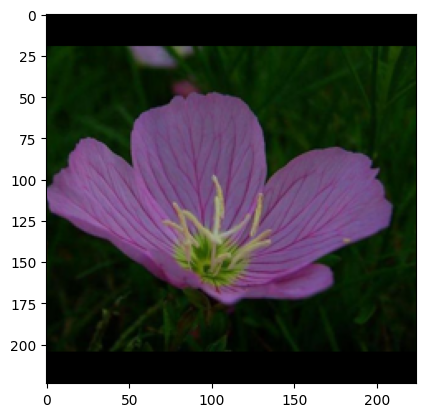

In [5]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

imshow(image=process_image('data/test/1/image_06752.jpg'))

## Class Prediction

 a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. 

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels. We used to load the data ([see here](#Save-the-checkpoint)). 

this method will take a path to an image and a model checkpoint, then return the probabilities and classes.

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # Implement the code to predict the class from an image file
    model.eval()
    model.cpu()
    image = process_image(image_path)
    image = torch.from_numpy(image).type(torch.FloatTensor)
    image = image.unsqueeze(0)

    with torch.no_grad():
      output = model(image)

    probs, indices = torch.topk(output,topk)
    classes = [cat_to_name.get(str(idx),'unknown') for idx in indices[0].tolist()]

    print(probs)
    print(classes)


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes
image_path = 'data/test/74/image_01200.jpg'
predict(image_path, model,5)
imshow(process_image(image_path))
plt.show()
